In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.ticker import FuncFormatter
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score
from typing import Optional
import torch

In [2]:
def c2st(
    X: np.ndarray,
    Y: np.ndarray,
    seed: int = 42,
    n_folds: int = 10,
    scoring: str = "accuracy",
    z_score: bool = True,
    noise_scale: Optional[float] = None,
) -> np.ndarray:
    if z_score:
        X_mean = np.mean(X, axis=0)
        X_std = np.std(X, axis=0)
        X = (X - X_mean) / X_std
        Y = (Y - X_mean) / X_std

    if noise_scale is not None:
        X += noise_scale * np.random.randn(*X.shape)
        Y += noise_scale * np.random.randn(*Y.shape)

    ndim = X.shape[1]

    clf = MLPClassifier(
        activation="relu",
        hidden_layer_sizes=(10 * ndim, 10 * ndim),
        max_iter=10000,
        solver="adam",
        random_state=seed,
    )

    data = np.concatenate((X, Y))
    target = np.concatenate(
        (
            np.zeros((X.shape[0],)),
            np.ones((Y.shape[0],)),
        )
    )

    shuffle = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    scores = cross_val_score(clf, data, target, cv=shuffle, scoring=scoring)

    scores = np.mean(scores).astype(np.float32)
    return np.atleast_1d(scores)

def c2st_auc(X: np.ndarray,
    Y: np.ndarray,
    seed: int = 1,
    n_folds: int = 5,
    z_score: bool = True,
    noise_scale: Optional[float] = None) -> np.ndarray:
    return c2st(
        X,
        Y,
        seed=seed,
        n_folds=n_folds,
        scoring="roc_auc",
        z_score=z_score,
        noise_scale=noise_scale,
    )

def filter_quantiles_25(matrix):
    q25, q75 = np.percentile(matrix, [2.5, 97.5], axis=0)
    mask = (matrix >= q25) & (matrix <= q75)
    filtered_lists = [matrix[mask[:, i], i] for i in range(matrix.shape[1])]
    max_len = max(len(lst) for lst in filtered_lists)
    padded_arrays = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in filtered_lists]
    
    data = np.array(padded_arrays).T
    new_data = data[~np.isnan(data).any(axis=1)]

    return new_data

def gaussian_kernel_matrix(X, Y, sigma=1.0):
    """Compute the Gaussian (RBF) kernel matrix between X and Y."""
    X_sqnorms = np.sum(X**2, axis=1).reshape(-1, 1)
    Y_sqnorms = np.sum(Y**2, axis=1).reshape(1, -1)
    cross_terms = -2.0 * np.dot(X, Y.T)
    exponent = X_sqnorms + Y_sqnorms + cross_terms
    return np.exp(-exponent / (2 * sigma**2))

def compute_MMD(sample, true_value, sigma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between sample and true_value
    using the Gaussian kernel.
    """
    K_sample = gaussian_kernel_matrix(sample, sample, sigma)
    K_true_value = gaussian_kernel_matrix(true_value, true_value, sigma)
    K_mixed = gaussian_kernel_matrix(sample, true_value, sigma)

    # Compute average values
    avg_sample = np.mean(K_sample)
    avg_true_value = np.mean(K_true_value)
    avg_mixed = np.mean(K_mixed)

    # MMD squared statistic
    mmd_squared = avg_sample + avg_true_value - 2 * avg_mixed
    return np.sqrt(mmd_squared)

In [3]:
true_dataset = sio.loadmat("paper2_BVCBM_synthetic_datasets.mat")
theta_true1 = true_dataset["param3"][:,[3,4,8]]
true_value_repeated1 = np.tile(theta_true1, (10000, 1))

snpe_syn1_round1 = sio.loadmat("Result/BVCBM_syn3_SNPE_round1.mat")["theta"][:,[3,4,8]]
snpe_syn1_round3 = sio.loadmat("Result/BVCBM_syn3_SNPE_round3.mat")["theta"][:,[3,4,8]]
snpe_syn1_round5 = sio.loadmat("Result/BVCBM_syn3_SNPE_round5.mat")["theta"][:,[3,4,8]]

smc_syn1_round1 = sio.loadmat("Result/BVCBM_3paras_synthhetic3 , simultation 12500.mat")["part_vals"][:,[3,4,8]]
smc_syn1_round3 = sio.loadmat("Result/BVCBM_3paras_synthhetic3 , simultation 29000.mat")["part_vals"][:,[3,4,8]]
smc_syn1_round5 = sio.loadmat("Result/BVCBM_3paras_synthhetic3 , simultation 55000.mat")["part_vals"][:,[3,4,8]]

snpe_syn1_1k = sio.loadmat("Result/BVCBM_syn3_SNPE_1k.mat")["theta_new"]
snpe_syn1_10k = sio.loadmat("Result/BVCBM_syn3_SNPE_round1.mat")["theta"][:,[3,4,8]]
snpe_syn1_50k = sio.loadmat("Result/BVCBM_syn3_SNPE_50k.mat")["theta_new"]

sbl_syn1_round1 = sio.loadmat("Result/BVCBM_BSL_3para_synthetic3 , simultation 100.mat")["theta"][:,[3,4,8]]
sbl_syn1_round3 = sio.loadmat("Result/BVCBM_BSL_3para_synthetic3 , simultation 300.mat")["theta"][:,[3,4,8]]
sbl_syn1_round5 = sio.loadmat("Result/BVCBM_BSL_3para_synthetic3 , simultation 500.mat")["theta"][:,[3,4,8]]

smc_abc = []
smc_abc.append(c2st_auc(smc_syn1_round1, true_value_repeated1,noise_scale = 1))
smc_abc.append(c2st_auc(smc_syn1_round3, true_value_repeated1,noise_scale = 1))
smc_abc.append(c2st_auc(smc_syn1_round5, true_value_repeated1,noise_scale = 1))

SNPE = []
SNPE.append(c2st_auc(snpe_syn1_round1, true_value_repeated1,noise_scale = 1))
SNPE.append(c2st_auc(snpe_syn1_round3, true_value_repeated1,noise_scale = 1))
SNPE.append(c2st_auc(snpe_syn1_round5, true_value_repeated1,noise_scale = 1))

npe = []
npe.append(c2st_auc(snpe_syn1_1k, true_value_repeated1,noise_scale = 1))
npe.append(c2st_auc(snpe_syn1_10k, true_value_repeated1,noise_scale = 1))
npe.append(c2st_auc(snpe_syn1_50k, true_value_repeated1,noise_scale = 1))

bsl = []
bsl.append(c2st_auc(sbl_syn1_round1, true_value_repeated1,noise_scale = 1))
bsl.append(c2st_auc(sbl_syn1_round3, true_value_repeated1,noise_scale = 1))
bsl.append(c2st_auc(sbl_syn1_round5, true_value_repeated1,noise_scale = 1))

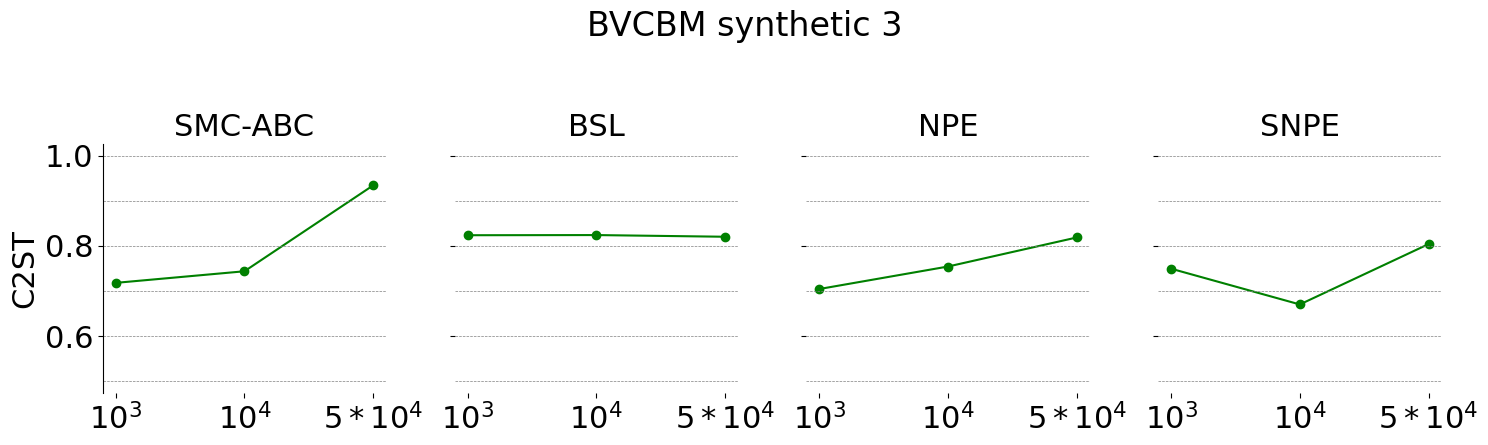

In [4]:
# Custom x values for the plot to make intervals appear equal
custom_x_vals = [1, 2, 3]

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

# Plot the data on the respective axes
methods = [smc_abc, bsl, npe, SNPE]
labels = ['SMC-ABC', 'BSL', 'NPE', 'SNPE']
colors = ['green', 'green']

for i, (method, label) in enumerate(zip(methods, labels)):
    ax = axes[i]
    ax.plot(custom_x_vals, method, '-o', color=colors[0])
    ax.set_title(label, fontsize=22)
    ax.set_xticks(custom_x_vals)
    ax.set_xticklabels([r'$10^3$', r'$10^4$', r'$5*10^4$'], fontsize=22)

    # Adding horizontal grey lines for each y-axis value
    for y_value in np.linspace(0.5, 1.0, 6):  # Adjust the range and number of lines if needed
        ax.axhline(y=y_value, color='grey', linestyle='--', linewidth=0.5)

    # Remove the box around the subplot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Only keep the left y-axis visible for the first subplot and display y-axis values for all subplots
    if i == 0:
        ax.spines['left'].set_visible(True)
        ax.set_ylabel('C2ST', fontsize=22)
    ax.yaxis.tick_left()
    
    # Set y-tick font size
    ax.tick_params(axis='y', labelsize=22)

# Title for the whole figure
fig.suptitle('BVCBM synthetic 3', fontsize=24, y=1.1)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()


In [5]:
smc_syn1_25 = []
smc_syn1_25.append(c2st_auc(filter_quantiles_25(smc_syn1_round1), true_value_repeated1,noise_scale = 1))
smc_syn1_25.append(c2st_auc(filter_quantiles_25(smc_syn1_round3), true_value_repeated1,noise_scale = 1))
smc_syn1_25.append(c2st_auc(filter_quantiles_25(smc_syn1_round5), true_value_repeated1,noise_scale = 1))

snpe_syn1_25 = []
snpe_syn1_25.append(c2st_auc(filter_quantiles_25(snpe_syn1_round1), true_value_repeated1,noise_scale = 1))
snpe_syn1_25.append(c2st_auc(filter_quantiles_25(snpe_syn1_round3), true_value_repeated1,noise_scale = 1))
snpe_syn1_25.append(c2st_auc(filter_quantiles_25(snpe_syn1_round5), true_value_repeated1,noise_scale = 1))

bsl_syn1_25 = []
bsl_syn1_25.append(c2st_auc(filter_quantiles_25(sbl_syn1_round1), true_value_repeated1,noise_scale = 1))
bsl_syn1_25.append(c2st_auc(filter_quantiles_25(sbl_syn1_round3), true_value_repeated1,noise_scale = 1))
bsl_syn1_25.append(c2st_auc(filter_quantiles_25(sbl_syn1_round5), true_value_repeated1,noise_scale = 1))

npe_syn1_25 = []
npe_syn1_25.append(c2st_auc(filter_quantiles_25(snpe_syn1_1k), true_value_repeated1,noise_scale = 1))
npe_syn1_25.append(c2st_auc(filter_quantiles_25(snpe_syn1_10k), true_value_repeated1,noise_scale = 1))
npe_syn1_25.append(c2st_auc(filter_quantiles_25(snpe_syn1_50k), true_value_repeated1,noise_scale = 1))

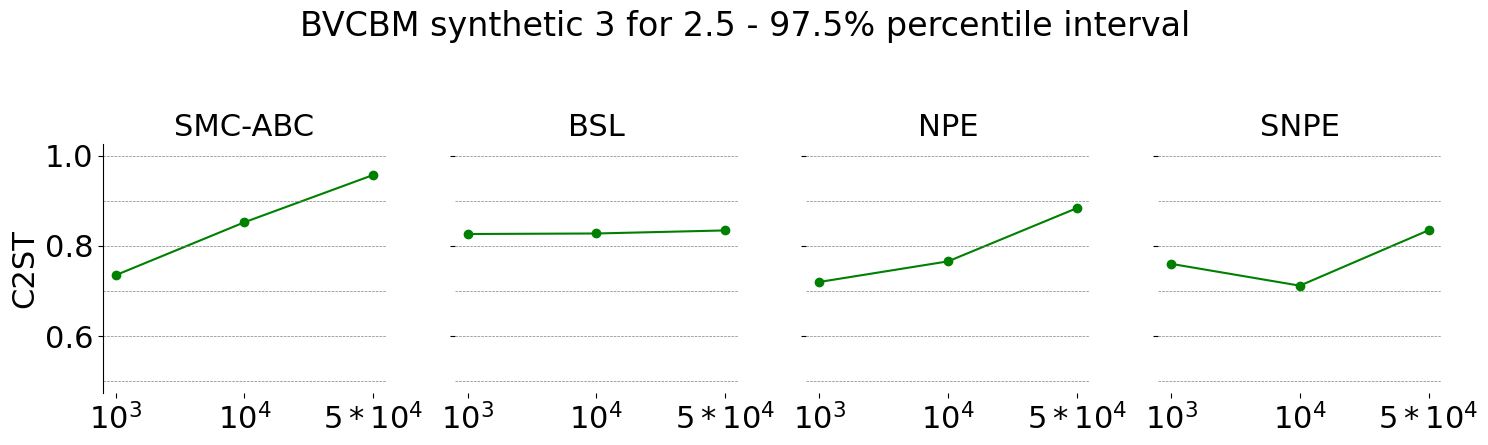

In [6]:
# Custom x values for the plot to make intervals appear equal
custom_x_vals = [1, 2, 3]

# Set up the figure and axes
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

# Plot the data on the respective axes
methods = [smc_syn1_25, bsl_syn1_25, npe_syn1_25, snpe_syn1_25]
labels = ['SMC-ABC', 'BSL', 'NPE', 'SNPE']
colors = ['green', 'green']

for i, (method, label) in enumerate(zip(methods, labels)):
    ax = axes[i]
    ax.plot(custom_x_vals, method, '-o', color=colors[0], label='Gaussian Linear')
    ax.set_title(label, fontsize=22)
    ax.set_xticks(custom_x_vals)
    ax.set_xticklabels([r'$10^3$', r'$10^4$', r'$5*10^4$'], fontsize=22)

    # Adding horizontal grey lines for each y-axis value
    for y_value in np.linspace(0.5, 1.0, 6):  # Adjust the range and number of lines if needed
        ax.axhline(y=y_value, color='grey', linestyle='--', linewidth=0.5)

    # Remove the box around the subplot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Only keep the left y-axis visible for the first subplot and display y-axis values for all subplots
    if i == 0:
        ax.spines['left'].set_visible(True)
        ax.set_ylabel('C2ST', fontsize=22)
    ax.yaxis.tick_left()
    
    # Set y-tick font size
    ax.tick_params(axis='y', labelsize=22)

# Title for the whole figure
fig.suptitle('BVCBM synthetic 3 for 2.5 - 97.5% percentile interval', fontsize=24, y=1.1)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()


In [ ]:
# Sample data for demonstration
np.random.seed(42)

# Assuming data for each method is stored in a dictionary
# Replace the random data with your actual data
data = {
    "SMC-ABC": sio.loadmat("Result/BVCBM_3paras_synthhetic3 , simultation 55000.mat")["part_vals"][:,[3,4,8]],
    "BSL": sio.loadmat("Result/BVCBM_BSL_3para_synthetic3 , simultation 500.mat")["theta"][:,[3,4,8]],
    "NPE": sio.loadmat("Result/BVCBM_syn3_SNPE_50k.mat")["theta_new"],
    "SNPE": sio.loadmat("Result/BVCBM_syn3_SNPE_round5.mat")["theta"][:,[3,4,8]],
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, (method, datasets) in zip(axes, data.items()):
    bp = ax.boxplot(datasets, patch_artist=True, widths=0.6)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(method, fontsize=22)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['$g_{age}^1$', r'$\tau$', '$g_{age}^2$'], fontsize=22)
    
    
    # Set y-tick font size
    ax.tick_params(axis='y', labelsize=22)

    if method == "SMC-ABC":  # add legend only to the first subplot for clarity
        ax.set_ylabel("$\mu_{pred} - \mu_{0}$", fontsize=22)
        ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], 
                  ['$g_{age}^1$', r'$\tau$', '$g_{age}^2$'], fontsize=22)

fig.suptitle('BVCBM synthetic 3', fontsize=24, y=1.1)

plt.tight_layout()
plt.show()

